# Data Cube populated with data obtained from the Weather and Geophysical Extremes Digital Twin (DT) – ExtremeDT

## This notebook covers:
- discovering available data cubes and their S3 URLs,
- loading data cubes from the Destination Earth Data Lake,
- plotting maps for a selected area, time range, and variable,
- plotting time series for a selected variable at a specific location.

To run this notebook, **access to the ISLET service and the S3 interface is required**.
Instructions on how to request the necessary permissions are available here:  
https://destine-data-lake-docs.data.destination-earth.eu/en/latest/my_datalake_services/How-to-request-for-islet-roles-on-My-DataLake-Services/How-to-request-for-islet-roles-on-My-DataLake-Services.html

The notebook demonstrates **basic data handling and visualisation workflows**
using ExtremeDT data, illustrated with examples for **each type of available data cube**.

## Prepre your environment

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import dask
import requests
import boto3
from getpass import getpass

## Authentication and connection with object storage

To access the data, authentication is required. Please provide your access key and secret key (how to obtain them: https://destine-data-lake-docs.data.destination-earth.eu/en/latest/my_datalake_services/How-to-obtain-eodata-S3-keys-through-My-DataLake-Services/How-to-obtain-eodata-S3-keys-through-My-DataLake-Services.html), and define the endpoint, bucket, and region.

In [2]:
access_key = input("Please input your access key: ")
secret_key = getpass("Please input your secret key: ")

name = 'boto3'
endpoint_url='https://s3.lumi.data.destination-earth.eu'
region_name='DEDL-LUMI'

Available Data

Print available data: paths with filenames.

In [3]:
try:
    s3 = boto3.client(
        's3',
        aws_access_key_id=access_key,
        aws_secret_access_key=secret_key,
        endpoint_url=endpoint_url,
        region_name=region_name
    )

    # List all buckets
    buckets = s3.list_buckets()['Buckets']
    print("Buckets available:")
    for b in buckets:
        print("-", b['Name'])

    # Choose a bucket (replace with your bucket name)
    bucket_name = buckets[0]['Name']
    print(f"\nObjects inside bucket: {bucket_name}")

    response = s3.list_objects_v2(Bucket=bucket_name)

    if 'Contents' in response:
        for obj in response['Contents']:
            print(f"- {obj['Key']} (Size: {obj['Size']} bytes)")
    else:
        print("No objects found in this bucket.")

except Exception as issue:
    print("The following error occurred:")
    print(issue)

Buckets available:
- dedl_datacubes

Objects inside bucket: dedl_datacubes
- ExtremeDT/ (Size: 0 bytes)
- ExtremeDT/dtextreme_accumulated_20251128.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251129.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251130.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251201.nc (Size: 100821466910 bytes)
- ExtremeDT/dtextreme_accumulated_20251202.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251203.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251204.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251207.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251208.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251209.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251212.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextreme_accumulated_20251215.nc (Size: 100821476318 bytes)
- ExtremeDT/dtextrem

## About the data

The following data cubes are available:
- **dtextreme_accumulated**
- **dtextreme_height_levels**
- **dtextreme_instantaneous**
- **dtextreme_means**

### dtextreme_accumulated
Consists of five variables:
- **sf** – Snowfall  
- **ssr** – Surface net short-wave (solar) radiation  
- **ttr** – Top net long-wave (thermal) radiation  
- **ro** – Runoff  
- **tp** – Total precipitation  

### dtextreme_height_levels
Consists of two variables:
- **100u** – 100 metre U wind component  
- **100v** – 100 metre V wind component  

### dtextreme_instantaneous
Consists of five variables:
- **sp** – Surface pressure  
- **10u** – 10 metre U wind component  
- **10v** – 10 metre V wind component  
- **2t** – 2 metre temperature  
- **2d** – 2 metre dewpoint temperature  

### dtextreme_means
Consists of one variable:
- **litota6** – Averaged total lightning flash density over the last 6 hours  

### Temporal Resolution
The data are provided with a **1-hour time step**.

### File nameing convention:
dtextreme_<type_of_variable>_YYYYMMDD.nc
YYYYMMDD - is the date when forecast starts (step 0)

## Let's make some test

### Area of interest

Upload data for selected area and verify what variables are provided. In this case uplaod data for Africa. List of available variables should be returend.


In [ ]:
s3_url = f"s3://dedl_datacubes/ExtremeDT/dtextreme_instantaneous_20251130.nc"

africa_bbox = [-20,     # West
                -40,    # South
                60,     # East
                40]     #North

africa_dt = xr.open_dataset(
            s3_url,
            engine="h5netcdf",
            chunks="auto",
            backend_kwargs={
                "storage_options": {
                    "key": access_key,
                    "secret": secret_key,
                    "client_kwargs": {
                        "endpoint_url": endpoint_url,
                        "region_name": region_name,
                    },
                }
            },
        ).sel(lon=slice(africa_bbox[0], 
                                            africa_bbox[2]), 
                                lat=slice(africa_bbox[3], 
                                            africa_bbox[1]),
                                                         )
        
print(africa_dt.var)
list(africa_dt.keys())        

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 10GB
Dimensions:  (time: 97, lon: 2279, lat: 2276)
Coordinates:
  * time     (time) datetime64[ns] 776B 2025-11-30 ... 2025-12-04
  * lon      (lon) float64 18kB -19.97 -19.94 -19.9 -19.87 ... 59.92 59.95 59.99
  * lat      (lat) float64 18kB 39.99 39.95 39.92 39.88 ... -39.92 -39.95 -39.99
Data variables:
    sp       (time, lat, lon) float32 2GB dask.array<chunksize=(2, 1138, 569), meta=np.ndarray>
    10u      (time, lat, lon) float32 2GB dask.array<chunksize=(2, 1138, 569), meta=np.ndarray>
    10v      (time, lat, lon) float32 2GB dask.array<chunksize=(2, 1138, 569), meta=np.ndarray>
    2t       (time, lat, lon) float32 2GB dask.array<chunksize=(2, 1138, 569), meta=np.ndarray>
    2d       (time, lat, lon) float32 2GB dask.array<chunksize=(2, 1138, 569), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.5.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Cen

['sp', '10u', '10v', '2t', '2d']

Plot map of air temperature for Africa.

Text(0, 0.5, 'Latitude')

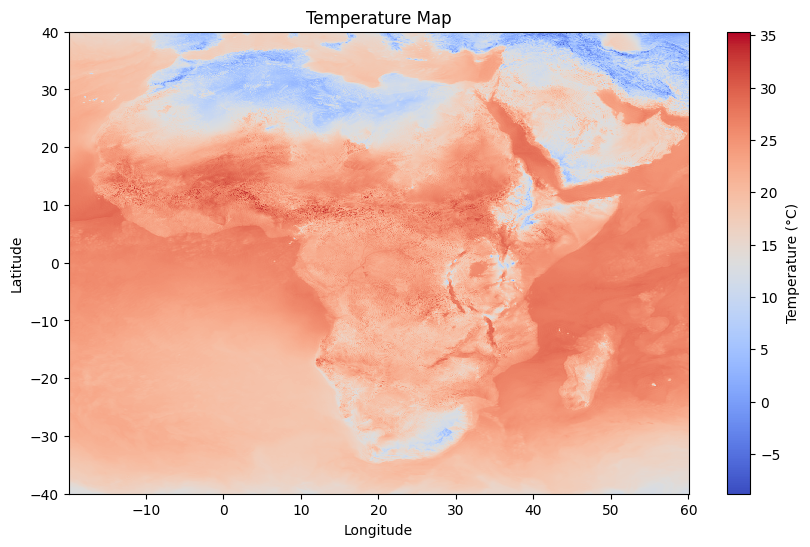

In [16]:
import matplotlib.pyplot as plt

list(africa_dt.keys())
#africa_dt.to_netcdf('africa_data.nc')

lon = africa_dt['lon']
lat = africa_dt['lat']
temperature = africa_dt['2t'][0] - 273.15 # Conversion to Celcius degrees

plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, temperature, cmap='coolwarm')
plt.colorbar(label='Temperature (°C)')
plt.title('Temperature Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Get data for specific time range

Select spatial extent and define the time range (start and end dates must be provided)

In [ ]:
africa_dt = xr.open_dataset(
            s3_url,
            engine="h5netcdf",
            chunks="auto",
            backend_kwargs={
                "storage_options": {
                    "key": access_key,
                    "secret": secret_key,
                    "client_kwargs": {
                        "endpoint_url": endpoint_url,
                        "region_name": region_name,
                    },
                }
            },
        ).sel(lon=slice(africa_bbox[0], 
                                            africa_bbox[2]), 
                                lat=slice(africa_bbox[3], 
                                            africa_bbox[1]),
                                time=slice('20251130T000000', '20251202T000000') # Time selection requires specifying the start and end of the desired interval
                                                         )
        
print(africa_dt.time)        

<xarray.DataArray 'time' (time: 49)> Size: 392B
array(['2025-11-30T00:00:00.000000000', '2025-11-30T01:00:00.000000000',
       '2025-11-30T02:00:00.000000000', '2025-11-30T03:00:00.000000000',
       '2025-11-30T04:00:00.000000000', '2025-11-30T05:00:00.000000000',
       '2025-11-30T06:00:00.000000000', '2025-11-30T07:00:00.000000000',
       '2025-11-30T08:00:00.000000000', '2025-11-30T09:00:00.000000000',
       '2025-11-30T10:00:00.000000000', '2025-11-30T11:00:00.000000000',
       '2025-11-30T12:00:00.000000000', '2025-11-30T13:00:00.000000000',
       '2025-11-30T14:00:00.000000000', '2025-11-30T15:00:00.000000000',
       '2025-11-30T16:00:00.000000000', '2025-11-30T17:00:00.000000000',
       '2025-11-30T18:00:00.000000000', '2025-11-30T19:00:00.000000000',
       '2025-11-30T20:00:00.000000000', '2025-11-30T21:00:00.000000000',
       '2025-11-30T22:00:00.000000000', '2025-11-30T23:00:00.000000000',
       '2025-12-01T00:00:00.000000000', '2025-12-01T01:00:00.000000000',
   

## Obtain data for specific variable and time

Obtain surface pressure data from 30th of November to 2nd of December.

In [ ]:
africa_dt = xr.open_dataset(
            s3_url,
            engine="h5netcdf",
            chunks="auto",
            backend_kwargs={
                "storage_options": {
                    "key": access_key,
                    "secret": secret_key,
                    "client_kwargs": {
                        "endpoint_url": endpoint_url,
                        "region_name": region_name,
                    },
                }
            },
        )['sp'].sel(lon=slice(africa_bbox[0],                                   # Variable selection
                                            africa_bbox[2]), 
                                lat=slice(africa_bbox[3], 
                                            africa_bbox[1]),
                                time=slice('20251130T000000', '20251202T000000') # Time selection requires specifying the start and end of the desired interval
                                                         )
        
print(africa_dt.var)

<bound method DataArrayAggregations.var of <xarray.DataArray 'sp' (time: 49, lat: 2276, lon: 2279)> Size: 1GB
dask.array<getitem, shape=(49, 2276, 2279), dtype=float32, chunksize=(2, 1138, 1710), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 392B 2025-11-30 ... 2025-12-02
  * lon      (lon) float64 18kB -19.97 -19.94 -19.9 -19.87 ... 59.92 59.95 59.99
  * lat      (lat) float64 18kB 39.99 39.95 39.92 39.88 ... -39.92 -39.95 -39.99
Attributes:
    standard_name:     surface_air_pressure
    long_name:         Surface pressure
    units:             Pa
    param:             0.3.0
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  2560>


Plot map of surface pressure over Africa for first time step (2025-11-30 00:00).

Text(0, 0.5, 'Latitude')

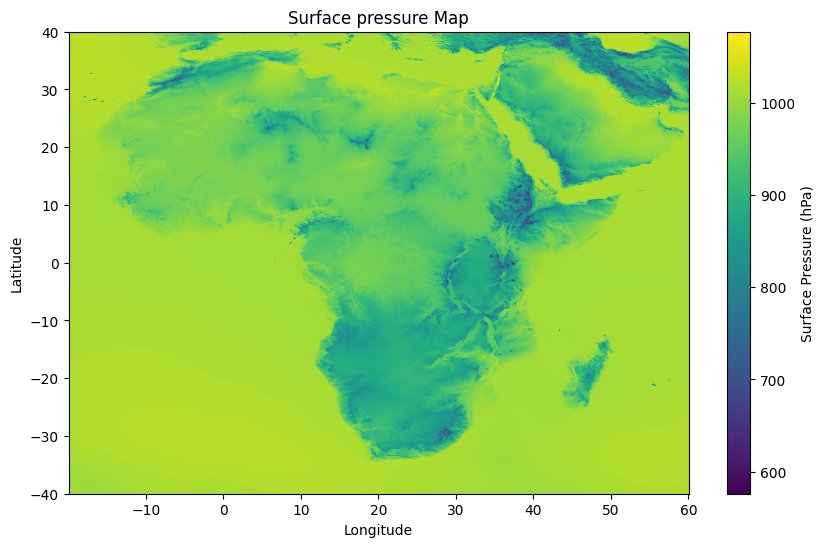

In [ ]:
lon = africa_dt['lon']
lat = africa_dt['lat']
surface_pressure_pa = africa_dt[0]              # Selection of first time step and conversion to hectoPascals
surface_pressure = surface_pressure_pa / 100    # Conversion to hectoPascals

plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, surface_pressure, cmap='viridis')
plt.colorbar(label='Surface Pressure (hPa)')
plt.title('Surface pressure Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Time series

Verify if it is possible to create time series chart (for 96 hours) from DT output - air temperature over Nairobi.

In [24]:
africa_bbox = [-20,     # West
                -40,    # South
                60,     # East
                40]     #North

africa_dt = xr.open_dataset(
            s3_url,
            engine="h5netcdf",
            chunks="auto",
            backend_kwargs={
                "storage_options": {
                    "key": access_key,
                    "secret": secret_key,
                    "client_kwargs": {
                        "endpoint_url": endpoint_url,
                        "region_name": region_name,
                    },
                }
            },
            #decode_cf=False,
        )['2t'].sel(lon=slice(africa_bbox[0], 
                                            africa_bbox[2]), 
                                lat=slice(africa_bbox[3], 
                                            africa_bbox[1]),
                                                         )

Create a chart.

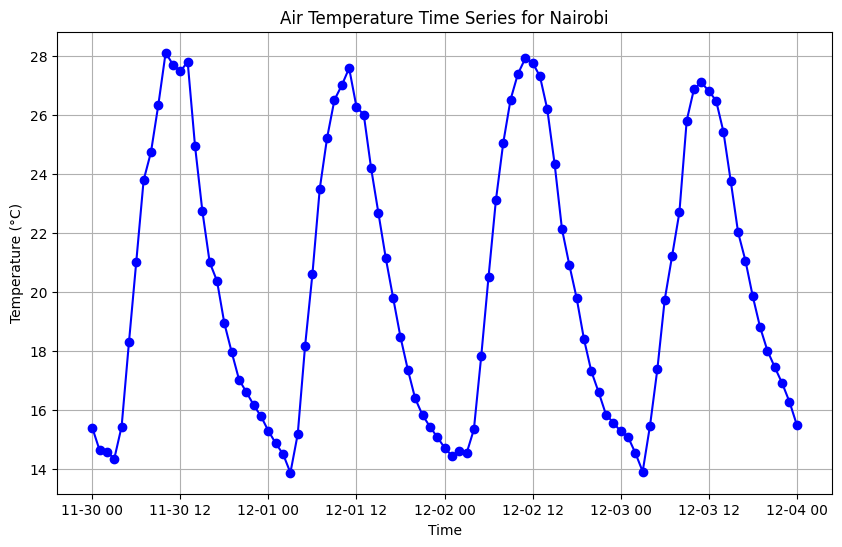

In [25]:
# Define Nairobi coordinates
nairobi_lat = -1.286389
nairobi_lon = 36.817223

lat = africa_dt['lat']
lon = africa_dt['lon']
nearest_lat_idx = np.abs(lat - nairobi_lat).argmin()
nearest_lon_idx = np.abs(lon - nairobi_lon).argmin()

temperature_nairobi = africa_dt[:, nearest_lat_idx, nearest_lon_idx] - 273.15
time_values = africa_dt.time.values

plt.figure(figsize=(10, 6))
plt.plot(time_values, temperature_nairobi, marker='o', color='b')
plt.title('Air Temperature Time Series for Nairobi')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

## DTExtreme Accumulated - data cube

Now, let’s try something with another data cube — for example, the accumulated one. In this example, we will plot a total precipitation map for Europe for 05.12.2025, based on the forecast issued on 03.12.2025.

Please note that total precipitation is an accumulated variable: it represents the sum of precipitation from the start of the forecast (step 0) up to the selected time step. In this case, from 00:00 on 3 December to 23:00 on 5 December.

In [ ]:
s3_url = f"s3://dedl_datacubes/ExtremeDT/dtextreme_accumulated_20251203.nc"

europe_bbox = [-25,    # West
               34,     # South
               45,     # East
               72]     # North

europe_dt = xr.open_dataset(
            s3_url,
            engine="h5netcdf",
            chunks="auto",
            backend_kwargs={
                "storage_options": {
                    "key": access_key,
                    "secret": secret_key,
                    "client_kwargs": {
                        "endpoint_url": endpoint_url,
                        "region_name": region_name,
                    },
                }
            },
            #decode_cf=False,
        )['tp'].sel(lon=slice(europe_bbox[0],                                    # Variable selection - total precipitation ['tp']
                                            europe_bbox[2]), 
                                lat=slice(europe_bbox[3], 
                                            europe_bbox[1]),
                                time=slice('20251203T000000', '20251205T230000') # Time selection requires specifying the start and end of the desired interval
                                                         )

print(europe_dt.var)    

<bound method DataArrayAggregations.var of <xarray.DataArray 'tp' (time: 71, lat: 1081, lon: 1995)> Size: 612MB
dask.array<getitem, shape=(71, 1081, 1995), dtype=float32, chunksize=(2, 1081, 1283), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 568B 2025-12-03T01:00:00 ... 2025-12-05T23...
  * lon      (lon) float64 16kB -24.99 -24.96 -24.92 -24.89 ... 44.93 44.96 45.0
  * lat      (lat) float64 9kB 71.98 71.94 71.91 71.87 ... 34.08 34.05 34.01
Attributes:
    long_name:         Total precipitation
    units:             m
    param:             193.128.0
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  2560>


Text(0, 0.5, 'Latitude')

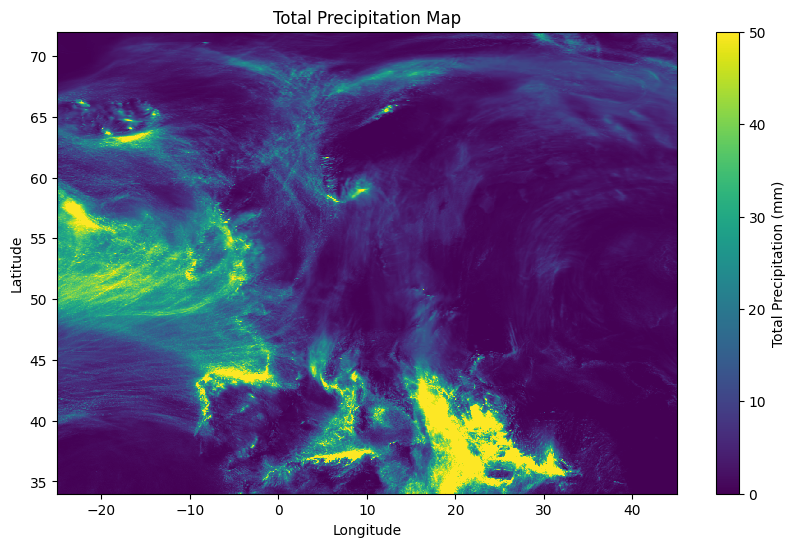

In [ ]:
lon = europe_dt['lon']
lat = europe_dt['lat']

total_p_meters = europe_dt[70]     # Select a specific time step (accumulated precipitation in meters - as 70th time step refers to 05.12.2025 23:00, choose 70)
total_p = total_p_meters * 1000    # Convert to millimeters

plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, total_p, cmap='viridis', vmin=0, vmax=50)
plt.colorbar(label='Total Precipitation (mm)')
plt.title('Total Precipitation Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


## DTExtreme at Hight Levels - data cube

Now, let’s try another data cube — this time for **wind at 100 m**, using the horizontal wind components **`100u`** and **`100v`**.

In this example, we will generate **maps for Japan**:
- a **wind speed map**,
- a **wind speed map with wind direction**.

### Wind speed formula

The wind components `u` and `v` form a horizontal wind vector.  
The wind speed (vector magnitude) is computed as:

`V = sqrt(u^2 + v^2)`

where:
- \(u\) is the zonal wind component (positive towards the east),
- \(v\) is the meridional wind component (positive towards the north).

Example: wind at 100 m over Japan

In [27]:
s3_url = f"s3://dedl_datacubes/ExtremeDT/dtextreme_height_levels_20251215.nc"

japan_bbox = [122,    # West
               20,     # South
               154,     # East
               46]     # North

japan_dt = xr.open_dataset(
            s3_url,
            engine="h5netcdf",
            chunks="auto",
            backend_kwargs={
                "storage_options": {
                    "key": access_key,
                    "secret": secret_key,
                    "client_kwargs": {
                        "endpoint_url": endpoint_url,
                        "region_name": region_name,
                    },
                }
            },
            #decode_cf=False,
        )[['100u', '100v']].sel(lon=slice(japan_bbox[0],                                    # Variable selection - 100 metre U wind component (100u) and 100 metre V wind component (100v)
                                            japan_bbox[2]), 
                                lat=slice(japan_bbox[3], 
                                            japan_bbox[1]),
                                time=slice('20251215T120000', '20251215T120000')            # Time selection requires specifying the start and end of the desired interval
                                                         )

print(japan_dt.var)    

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 5MB
Dimensions:  (time: 1, lat: 740, lon: 912)
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-12-15T12:00:00
  * lon      (lon) float64 7kB 122.0 122.0 122.1 122.1 ... 153.9 154.0 154.0
  * lat      (lat) float64 6kB 46.0 45.96 45.93 45.89 ... 20.09 20.05 20.02
Data variables:
    100u     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 740, 912), meta=np.ndarray>
    100v     (time, lat, lon) float32 3MB dask.array<chunksize=(1, 740, 912), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.5.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Dec 17 04:30:50 2025: cdo -sellonlatbox,-180,180,-90,90...
    CDO:          Climate Data Operators version 2.5.2 (https://mpimet.mpg.de...>


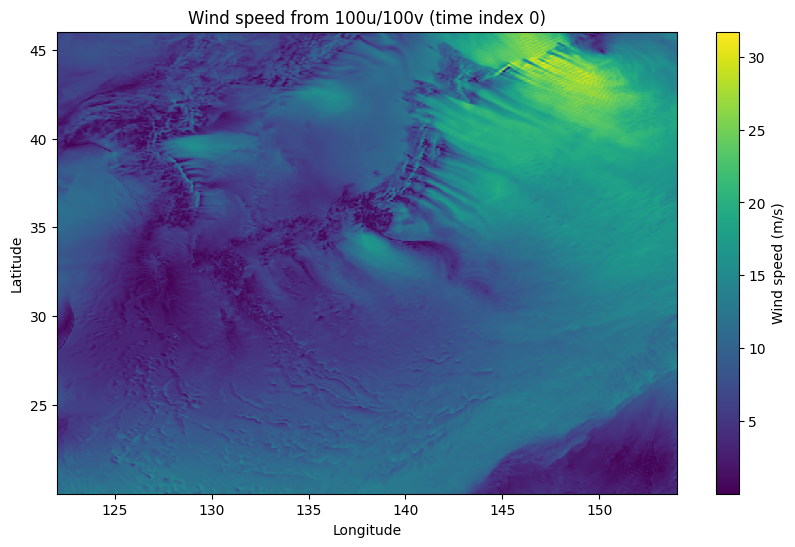

In [28]:
lon = japan_dt["lon"].values
lat = japan_dt["lat"].values

t_idx = 0  # pick time step (change as needed)

u = japan_dt["100u"].isel(time=t_idx)
v = japan_dt["100v"].isel(time=t_idx)

wind_speed = np.sqrt(u**2 + v**2)  # units: same as u/v (typically m/s)

plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, wind_speed, shading="auto", cmap="viridis")
plt.colorbar(label="Wind speed (m/s)")
plt.title(f"Wind speed from 100u/100v (time index {t_idx})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



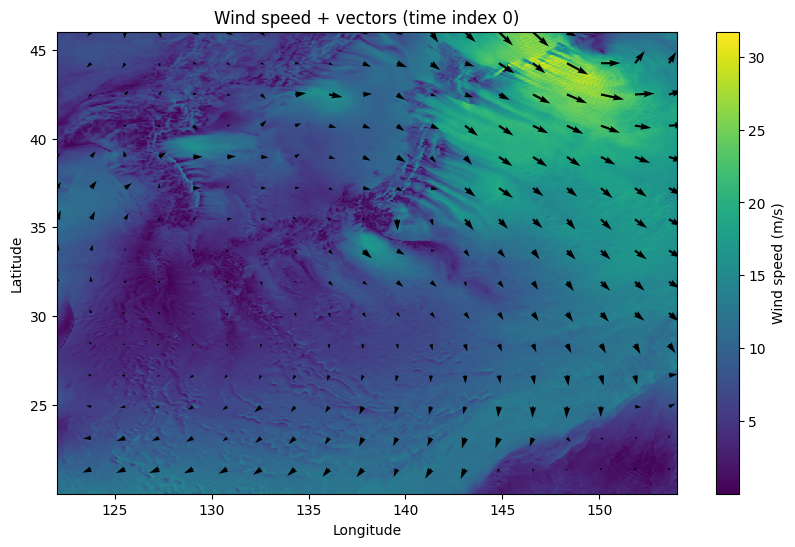

In [29]:
step = 50  # increase/decrease arrow density

plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, wind_speed, shading="auto", cmap="viridis")
plt.colorbar(label="Wind speed (m/s)")

plt.quiver(
    lon[::step], lat[::step],
    u.values[::step, ::step], v.values[::step, ::step],
    scale=700
)

plt.title(f"Wind speed + vectors (time index {t_idx})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## DTExtreme Mean encodings - data cube

Finally, we examine the **mean encodings** data cube, focusing on the variable
**Averaged total lightning flash density (last 6 hours)**.

The example covers **Brazil** and shows the **average lightning flash density**
between **00:00 and 06:00 on 2 December 2025**, providing a spatial overview of
recent thunderstorm activity.

In [ ]:
s3_url = f"s3://dedl_datacubes/ExtremeDT/dtextreme_means_20251202.nc"

brazil_bbox = [-75,     # West
                -35,    # South
                -34,     # East
                5]     #North

brazil_dt= xr.open_dataset(
            s3_url,
            engine="h5netcdf",
            chunks="auto",
            backend_kwargs={
                "storage_options": {
                    "key": access_key,
                    "secret": secret_key,
                    "client_kwargs": {
                        "endpoint_url": endpoint_url,
                        "region_name": region_name,
                    },
                }
            },
            #decode_cf=False,
        )['litota6'].sel(lon=slice(brazil_bbox[0],                                          # Variable selection - 100 metre U wind component (100u) and 100 metre V wind component (100v)
                                            brazil_bbox[2]), 
                                lat=slice(brazil_bbox[3], 
                                            brazil_bbox[1]),
                                time=slice('20251202T000000', '20251202T230000')            # Time selection requires specifying the start and end of the desired interval
                                                         )

print(brazil_dt.var)    

<bound method DataArrayAggregations.var of <xarray.DataArray 'litota6' (time: 3, lat: 1138, lon: 1168)> Size: 16MB
dask.array<getitem, shape=(3, 1138, 1168), dtype=float32, chunksize=(2, 996, 1168), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 24B 2025-12-02T06:00:00 ... 2025-12-02T18:...
  * lon      (lon) float64 9kB -74.98 -74.94 -74.91 ... -34.08 -34.05 -34.01
  * lat      (lat) float64 9kB 4.974 4.939 4.904 4.869 ... -34.92 -34.96 -34.99
Attributes:
    long_name:         Averaged total lightning flash density in the last 6 h...
    units:             km**-2 day**-1
    param:             4.128.0
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  2560>


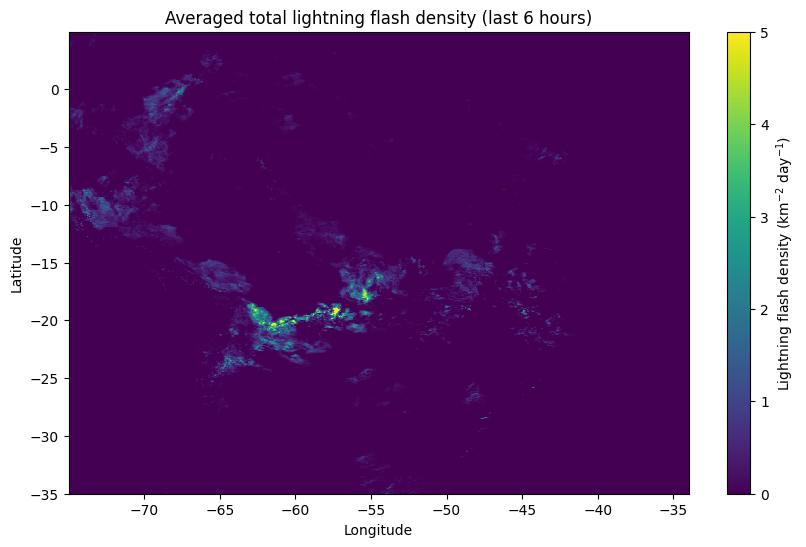

In [45]:
lon = brazil_dt["lon"].values
lat = brazil_dt["lat"].values

# select time step
lightning = brazil_dt[0]

plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, lightning, shading="auto", cmap="viridis",vmin=0, vmax=5
)

plt.colorbar(label="Lightning flash density (km$^{-2}$ day$^{-1}$)")
plt.title("Averaged total lightning flash density (last 6 hours)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
